# Options Pricing Using Machine Learning.

## Inroduction

In this project we are applying different machine learning methods to estimate Options contracts market prices based on various features. We compare our models'  errors to that of the Black-Scholes model as a baseline.

We use 3 different ML models, namely, **LightGBM**, **Neural Networks**, and **Support Vector Machines**. 

For data, the historical data of 98 options contarcs for past 3 years in Iran's Options market were used.

---

## Importing packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle


import lightgbm as lgbm
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV,KFold, GridSearchCV

from tensorflow.keras import layers, models
import tensorflow as tf

In [3]:
EPOCHS = 800
BATCH_SIZE = 256
VAL_SPLIT = 0.15
TRAIN = False # set to True for training again

SEED = 42
np.random.seed(SEED)

---

## Loading and processing data

In [6]:
df = pd.read_excel("option_prices_data.xlsx").dropna().reset_index().drop(columns=['index'])
cols = list(df.columns)
cols

['date_fa',
 'symbol',
 'exp_date',
 'close_price',
 'strike_price',
 'equity_price',
 'annual_volatility',
 'riskfree_rate',
 'time_until_exp',
 'BS']

In [7]:
print("Missing Values:")
df.isna().sum()

Missing Values:


date_fa              0
symbol               0
exp_date             0
close_price          0
strike_price         0
equity_price         0
annual_volatility    0
riskfree_rate        0
time_until_exp       0
BS                   0
dtype: int64

In [8]:
df

,date_fa,symbol,exp_date,close_price,strike_price,equity_price,annual_volatility,riskfree_rate,time_until_exp,BS
0,1400/03/10,ضخود70771,1400/07/07,32,3000,1740,0.444299,0.196389,0.5042,24.239068
1,1400/03/11,ضخود70771,1400/07/07,30,3000,1686,0.448107,0.196389,0.5000,19.314782
2,1400/03/12,ضخود70771,1400/07/07,37,3000,1738,0.462402,0.196389,0.4958,27.025510
3,1400/03/17,ضخود70771,1400/07/07,48,3000,1808,0.479096,0.196389,0.4750,36.700559
4,1400/03/18,ضخود70771,1400/07/07,53,3000,1894,0.498049,0.196389,0.4708,55.503608
...,...,...,...,...,...,...,...,...,...,...
4863,1399/11/19,ضغدر11191,1399/11/26,1003,10000,10990,0.582477,0.297657,0.0292,1157.298735
4864,1399/11/20,ضغدر11191,1399/11/26,1313,10000,11510,0.598842,0.297657,0.0250,1609.719453
4865,1399/11/21,ضغدر11191,1399/11/26,1887,10000,12060,0.601912,0.297657,0.0208,2125.992878
4866,1399/11/25,ضغدر11191,1399/11/26,2482,10000,12770,0.619110,0.297657,0.0042,2782.493790


In [9]:
descriptive = df.describe().T
# descriptive.to_csv("descriptive.csv")
descriptive

,count,mean,std,min,25%,50%,75%,max
close_price,4868.0,1048.384347,1553.900115,1.000000,137.000000,486.000000,1137.250000,11370.000000
strike_price,4868.0,5611.128595,6286.114667,500.000000,2000.000000,3000.000000,7000.000000,39750.000000
equity_price,4868.0,5708.069638,5934.679427,488.000000,2174.000000,2890.000000,6925.000000,37120.000000
annual_volatility,4868.0,0.514253,0.222192,0.187354,0.390653,0.487253,0.587536,6.820169
riskfree_rate,4868.0,0.290325,0.106985,0.173617,0.196389,0.294980,0.331172,0.486492
time_until_exp,4868.0,0.206605,0.166233,0.000000,0.087500,0.179200,0.291700,1.320800
BS,4868.0,1180.424673,1884.824974,-4480.000000,118.534691,496.495395,1236.836838,18273.157515


In [10]:
df["moneyness"] = (df["strike_price"] - df["equity_price"]).apply(
    lambda x: "ITM" if x > 0 else (lambda x: "OTM" if x < 0 else "ATM")(x)
)

df["time_group"] = df["time_until_exp"].apply(
    lambda x: "short_term" if x < 0.5 else "long_term"
)

In [11]:
symbols = df["symbol"].unique()
TRAIN_SIZE = 0.8

train_df = pd.DataFrame()
test_df = pd.DataFrame()

for symbol in symbols:
    section = df[df["symbol"] == symbol].sample(frac=1).copy()
    l = len(section)

    train_df = pd.concat([train_df,section.iloc[:int(l*TRAIN_SIZE),:]])
    test_df = pd.concat([test_df,section.iloc[int(l*TRAIN_SIZE):,:]])


In [12]:
len(symbols)

98

In [13]:
print("all data:")
print(df["moneyness"].value_counts())
print('\n============')
print("train data:")
print(train_df["moneyness"].value_counts())
print('\n============')
print("all data:")
print(test_df["moneyness"].value_counts())


all data:
OTM    2951
ITM    1909
ATM       8
Name: moneyness, dtype: int64

train data:
OTM    2357
ITM    1491
ATM       6
Name: moneyness, dtype: int64

all data:
OTM    594
ITM    418
ATM      2
Name: moneyness, dtype: int64


In [14]:
test_df["moneyness"].value_counts()

OTM    594
ITM    418
ATM      2
Name: moneyness, dtype: int64

In [15]:
train_df

,date_fa,symbol,exp_date,close_price,strike_price,equity_price,annual_volatility,riskfree_rate,time_until_exp,BS,moneyness,time_group
4,1400/03/18,ضخود70771,1400/07/07,53,3000,1894,0.498049,0.196389,0.4708,55.503608,ITM,short_term
62,1400/06/23,ضخود70771,1400/07/07,2,3000,2122,0.411762,0.196389,0.0667,0.063147,ITM,short_term
18,1400/04/07,ضخود70771,1400/07/07,56,3000,2163,0.520485,0.196389,0.3875,99.071829,ITM,short_term
0,1400/03/10,ضخود70771,1400/07/07,32,3000,1740,0.444299,0.196389,0.5042,24.239068,ITM,long_term
28,1400/04/21,ضخود70771,1400/07/07,81,3000,2095,0.421454,0.196389,0.3375,33.434641,ITM,short_term
...,...,...,...,...,...,...,...,...,...,...,...,...
4860,1399/11/14,ضغدر11191,1399/11/26,1353,10000,11490,0.545061,0.297657,0.0500,1701.657805,OTM,short_term
4849,1399/10/29,ضغدر11191,1399/11/26,560,10000,9380,0.476268,0.297657,0.1125,472.065071,ITM,short_term
4867,1399/11/26,ضغدر11191,1399/11/26,2117,10000,12730,0.614972,0.297657,0.0000,1365.000000,OTM,short_term
4836,1399/10/09,ضغدر11191,1399/11/26,3303,10000,12340,0.539483,0.297657,0.1958,3073.564990,OTM,short_term


In [16]:
test_df

,date_fa,symbol,exp_date,close_price,strike_price,equity_price,annual_volatility,riskfree_rate,time_until_exp,BS,moneyness,time_group
68,1400/06/31,ضخود70771,1400/07/07,1,3000,1814,0.439361,0.196389,0.0333,8.459631e-09,ITM,short_term
63,1400/06/24,ضخود70771,1400/07/07,1,3000,2103,0.411888,0.196389,0.0625,2.906379e-02,ITM,short_term
37,1400/05/13,ضخود70771,1400/07/07,44,3000,1971,0.371506,0.196389,0.2458,3.519341e+00,ITM,short_term
29,1400/04/22,ضخود70771,1400/07/07,79,3000,2060,0.421670,0.196389,0.3333,2.795615e+01,ITM,short_term
43,1400/05/23,ضخود70771,1400/07/07,34,3000,2139,0.336803,0.196389,0.2042,3.569365e+00,ITM,short_term
...,...,...,...,...,...,...,...,...,...,...,...,...
4842,1399/10/17,ضغدر11191,1399/11/26,1989,10000,11070,0.503151,0.297657,0.1625,1.819499e+03,OTM,short_term
4854,1399/11/06,ضغدر11191,1399/11/26,1813,10000,11420,0.546440,0.297657,0.0833,1.803542e+03,OTM,short_term
4835,1399/10/08,ضغدر11191,1399/11/26,3500,10000,12690,0.536448,0.297657,0.2000,3.402455e+03,OTM,short_term
4827,1399/09/26,ضغدر11191,1399/11/26,3492,10000,12360,0.602526,0.297657,0.2500,3.370322e+03,OTM,short_term


In [17]:
train_data = train_df[["strike_price", "equity_price", "annual_volatility", "riskfree_rate", "time_until_exp"]].values
train_labels = train_df["close_price"].values

test_data = test_df[["strike_price", "equity_price", "annual_volatility", "riskfree_rate", "time_until_exp"]].values
test_labels = test_df["close_price"].values

---

## Model training

### LightGBM

In [18]:
reg = lgbm.LGBMRegressor(
    # n_estimators=15000,
    # objective= 'mse',
    # learning_rate=0.002,
    # max_depth=32,
    # lambda_l1=30,
    # num_leaves =,
    # max_depth =
    )

param_grid = {
    "n_estimators": list(range(13000,20000,1000)),
    "learning_rate": np.arange(0.0001, 0.0021, 0.0002),
    "num_leaves":  list(range(30, 80, 10)),
    "max_depth": list(range(5, 30,4)),
    # "min_data_in_leaf":  list(range(200, 10000, 100)),
    # "lambda_l1": list(range( 0, 100, 5)),
    "reg_lambda": list(range(50, 100, 10)),
    # "min_gain_to_split": np.arange(0, 10,0.2)
}

lgb_search = RandomizedSearchCV(reg, param_grid,cv=3, n_iter=100, scoring='neg_mean_squared_error', verbose=3)
# eval_set = [(test_data, test_labels)]



In [20]:
if TRAIN:
    # lgb_search.fit(
    #     train_data,
    #     train_labels
    # )
    reg = lgbm.LGBMRegressor(
        n_estimators=16000,
        objective= 'mse',
        learning_rate=0.0008,
        max_depth=8,
        reg_lambda=80,
        num_leaves =30
        )
    reg.fit(
        train_data,
        train_labels
    )
    best_lgb_model = reg
    # print(lgb_search.best_params_)
    
    filename = 'best_lgb.sav'
    pickle.dump(best_lgb_model, open(filename, 'wb'))
else:
    # load the model from disk
    filename = 'best_lgb.sav'
    best_lgb_model = pickle.load(open(filename, 'rb'))

In [21]:
print(best_lgb_model.get_params())

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.0008, 'max_depth': 8, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 16000, 'n_jobs': -1, 'num_leaves': 30, 'objective': 'mse', 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 80, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [22]:
lgbm_pred = best_lgb_model.predict(test_data)

In [25]:

print("LightGBM test RMSE:", mean_squared_error(lgbm_pred, test_df["close_price"].values)**0.5)
print("Black-Sholes test RMSE:", mean_squared_error(test_df["BS"].values, test_df["close_price"].values)**0.5)

LightGBM test RMSE: 332.3933933819285
Black-Sholes test RMSE: 771.9785736192837


### Multi-layer Perceptron (Neural Nets)

In [26]:
scaler = StandardScaler()
train_data_sc = scaler.fit_transform(train_data)
test_data_sc = scaler.transform(test_data)

In [27]:
nn_model = models.Sequential(
    [
        layers.Dense(32, activation="relu", input_shape=[train_data.shape[1]]),
        layers.BatchNormalization(),
        layers.Dropout(0.15),
        layers.Dense(16, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.15),
        layers.Dense(8, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.15),
        layers.Dense(1, activation="relu"),
    ]
)

nn_model.compile(
    optimizer = "adam",
    loss = "mse",
    metrics = [tf.keras.metrics.RootMeanSquaredError()]
  )

In [28]:
nn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                192       
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1

In [29]:

if TRAIN:
    history_nn = nn_model.fit(
        x=train_data_sc,
        y=train_labels,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS*2,
        verbose="auto",
        validation_split=VAL_SPLIT
    )

    nn_model.save('model_3layers_with_dropout')
else:
    nn_model = tf.keras.models.load_model("model_3layers_with_dropout")

Epoch 1/1600
13/13 [==============================] - 1s 21ms/step - loss: 4007647.0000 - root_mean_squared_error: 2001.9109 - val_loss: 1170540.1250 - val_root_mean_squared_error: 1081.9150
Epoch 2/1600
13/13 [==============================] - 0s 5ms/step - loss: 4006667.2500 - root_mean_squared_error: 2001.6661 - val_loss: 1170480.1250 - val_root_mean_squared_error: 1081.8873
Epoch 3/1600
13/13 [==============================] - 0s 5ms/step - loss: 4004939.2500 - root_mean_squared_error: 2001.2344 - val_loss: 1170385.7500 - val_root_mean_squared_error: 1081.8436
Epoch 4/1600
13/13 [==============================] - 0s 5ms/step - loss: 4003352.7500 - root_mean_squared_error: 2000.8380 - val_loss: 1170241.5000 - val_root_mean_squared_error: 1081.7770
Epoch 5/1600
13/13 [==============================] - 0s 5ms/step - loss: 4001641.2500 - root_mean_squared_error: 2000.4103 - val_loss: 1170074.7500 - val_root_mean_squared_error: 1081.7000
Epoch 6/1600
13/13 [=============================

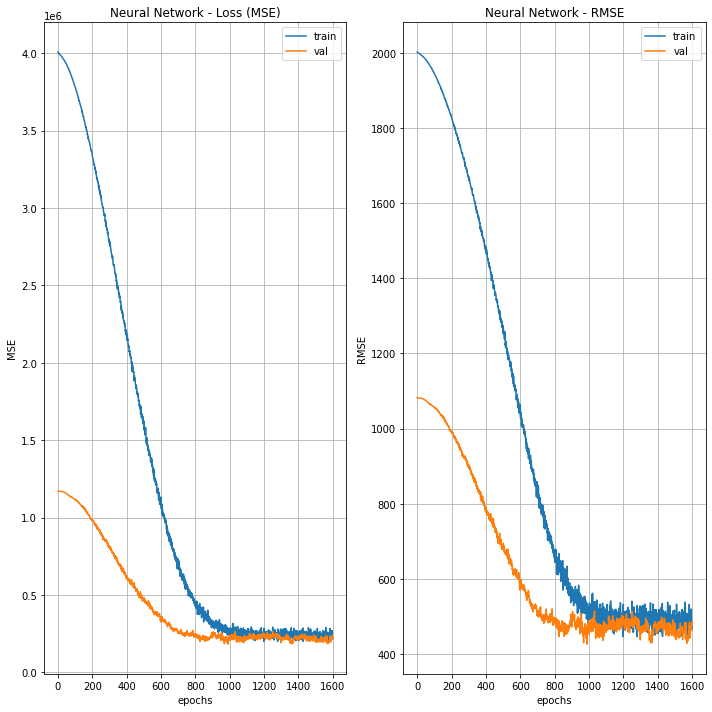

In [31]:

plt.figure(figsize=(10,10))


plt.subplot(1,2,1)
plt.plot(list(range(EPOCHS*2)), history_nn.history["loss"], label="train")
plt.plot(list(range(EPOCHS*2)), history_nn.history["val_loss"], label="val")
plt.title("Neural Network - Loss (MSE)")
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(list(range(EPOCHS*2)), history_nn.history["root_mean_squared_error"], label="train")
plt.plot(list(range(EPOCHS*2)), history_nn.history["val_root_mean_squared_error"], label="val")
plt.title("Neural Network - RMSE")
plt.xlabel("epochs")
plt.ylabel("RMSE")
plt.legend()

plt.tight_layout()
plt.grid()
plt.savefig('NN_learning_curve.png')



In [32]:

nn_pred = nn_model.predict(test_data_sc)

In [34]:

print("NN model 2 (with dropout)RMSE:\t",mean_squared_error(nn_pred, test_labels)**0.5)
print("Black-Scholes RMSE:\t\t",mean_squared_error(test_df["BS"], test_labels)**0.5)


NN model 2 (with dropout)RMSE:	 325.04384320334185
Black-Scholes RMSE:		 771.9785736192837


### Support Vector Regressor

In [35]:
params_dict = {
    'kernel' : ['poly', 'rbf', 'sigmoid'],
    'degree' : np.arange(3,6),
    'gamma': [1, 0.1, 0.5, 0.01, 0.005, 0.001, 0.0001, 0.00001],
    'C': list(range(5,500,20)),
    'shrinking':[True, False]
}
svr_model = SVR()

search = RandomizedSearchCV(
    svr_model,
    params_dict,
    cv=3,
    n_iter=15, scoring='neg_mean_squared_error',
    verbose=3
)

In [36]:
if TRAIN:
    # search.fit(
    #     train_data_sc,
    #     train_labels
    # )
    svr_model = SVR(
        C= 305,
        cache_size= 200,
        coef0= 0.0,
        degree= 3,
        epsilon= 0.1,
        gamma= 0.1,
        kernel= 'rbf',
        max_iter= -1,
        shrinking= False,
        tol= 0.001,
        verbose= False
    )
    svr_model.fit(
        train_data_sc,
        train_labels
    )
    best_svr_model = svr_model
    # print(search.best_params_)
    
    filename = 'best_SVR.sav'
    pickle.dump(best_svr_model, open(filename, 'wb'))
else:
    # load the model from disk
    filename = 'best_SVR.sav'
    best_svr_model = pickle.load(open(filename, 'rb'))

In [37]:
best_svr_model.get_params()

{'C': 305,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 0.1,
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': False,
 'tol': 0.001,
 'verbose': False}

In [38]:
svr_pred = best_svr_model.predict(test_data_sc)

In [40]:
print('SVR RMSE:\t\t', mean_squared_error(svr_pred, test_labels)**0.5)
print('Black-Scholes RMSE:\t', mean_squared_error(test_df["BS"], test_labels)**0.5)

SVR RMSE:		 600.5260059146941
Black-Scholes RMSE:	 771.9785736192837


In [26]:
# nn_model = tf.keras.models.load_model("model_3layers_with_dropout")
# nn_pred = nn_model.predict(test_data_sc)

# Final Results

In [42]:
print("Neural Network RMSE:\t",round(mean_squared_error(nn_pred, test_labels, squared=False),3))
print("LightGBM RMSE:\t\t",round(mean_squared_error(lgbm_pred, test_labels, squared=False),3))
print("SVR RMSE:\t\t",round(mean_squared_error(svr_pred, test_labels, squared=False),3))
print("Black Sholes RMSE:\t",round(mean_squared_error(test_df["BS"], test_labels, squared=False),3))


Neural Network RMSE:	 325.044
LightGBM RMSE:		 332.393
SVR RMSE:		 600.526
Black Sholes RMSE:	 771.979


It is shown that three ML models have outperformed the Black-sholes model. The Neural Net has had the best performance among the 3.

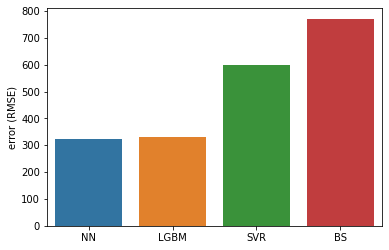

In [61]:
sns.barplot(data=pd.DataFrame(
    {
        "NN": [mean_squared_error(nn_pred, test_labels, squared=False)],
        "LGBM": [mean_squared_error(lgbm_pred, test_labels, squared=False)],
        "SVR": [mean_squared_error(svr_pred, test_labels, squared=False)],
        "BS": [mean_squared_error(test_df["BS"], test_labels, squared=False)]
    }
))
plt.ylabel("error (RMSE)");

In [44]:
full_nn_pred = nn_model.predict(scaler.transform(df[["strike_price", "equity_price", "annual_volatility", "riskfree_rate", "time_until_exp"]].values))
print("Neural Network full RMSE:\t",round(mean_squared_error(full_nn_pred,
                                                    df[["close_price"]].values, squared=False),3))

Neural Network full RMSE:	 306.011


In [45]:
full_lgb_pred = best_lgb_model.predict(df[["strike_price", "equity_price", "annual_volatility", "riskfree_rate", "time_until_exp"]].values)
print("LightGBM full RMSE:\t",round(mean_squared_error(full_lgb_pred,
                                                    df[["close_price"]].values, squared=False),3))

LightGBM full RMSE:	 295.605


In [46]:
full_svr_pred = best_svr_model.predict(scaler.transform(df[["strike_price", "equity_price", "annual_volatility", "riskfree_rate", "time_until_exp"]].values))
print("SVR full RMSE:\t",round(mean_squared_error(full_svr_pred,
                                                    df[["close_price"]].values, squared=False),3))

SVR full RMSE:	 613.005


In [47]:
print("Black Sholes full RMSE:\t",round(mean_squared_error(df["BS"].values, df[["close_price"]].values, squared=False),3))

Black Sholes full RMSE:	 846.745


In [48]:
def rmse(x,y):
    return(round(mean_squared_error(x, y, squared=False),2))

In [49]:
result = {}
for term in ["short_term", "long_term", "ALL"]:
    # print(">>",term+":",)    
    result[term] = {}    
    for moneyness in ["ITM", "OTM", "ATM", "ALL"]:
        if (moneyness == "ALL") and (term =="ALL"):
            data = test_df.copy()
        elif moneyness == "ALL":
            data = test_df[test_df["time_group"] == term].copy()
        elif term =="ALL":
            data = test_df[test_df["moneyness"] == moneyness].copy()
        else:
            data = test_df[(test_df["moneyness"]==moneyness) & (test_df["time_group"] == term)].copy()
        x = data[["strike_price", "equity_price", "annual_volatility", "riskfree_rate", "time_until_exp"]].values
        y = data[["close_price"]].values

        # print("\t"+moneyness+":",end="")
        result[term][moneyness] = []
        if len(data)==0:
            result[term][moneyness].append("No Data")
            result[term][moneyness].append("No Data")
            result[term][moneyness].append("No Data")
            result[term][moneyness].append("No Data")
            # print("\tNN: ", "No Data", end="\n\t\t")
            # print("SVR: ", "No Data", end="\n\t\t")
            # print("LGBM: ", "No Data")
            continue
        result[term][moneyness].append(rmse(nn_model.predict(scaler.transform(x)), y))
        result[term][moneyness].append(rmse(best_svr_model.predict(scaler.transform(x)), y))
        result[term][moneyness].append(rmse(best_lgb_model.predict(x), y))
        result[term][moneyness].append(rmse(data["BS"].values, y))
        # print("\tNN: ",rmse(model_2.predict(scaler.transform(x)), y) , end="\n\t\t")
        # print("SVR: ",rmse(best_svr_model.predict(scaler.transform(x)), y), end="\n\t\t")
        # print("LGBM: ",rmse(best_lgb_model.predict(x), y))
        

In [50]:
reform = {(outerKey, innerKey): values for outerKey, innerDict in result.items() for innerKey, values in innerDict.items()}
reform_df = pd.DataFrame(reform)
reform_df = reform_df.T
reform_df.columns = ["NN", "SVR", "LGBM","BS"]
reform_df

NN      SVR     LGBM       BS
short_term ITM   225.17    342.1   219.09   443.07
           OTM   340.56    732.9   396.41   914.97
           ATM   165.15   300.01   194.95   290.11
           ALL   298.53   603.77    335.1   757.44
long_term  ITM   808.96   386.37   254.59   614.32
           OTM   526.61   631.14   279.24  1319.76
           ATM  No Data  No Data  No Data  No Data
           ALL   679.46    525.9   267.47  1036.69
ALL        ITM   287.18   344.57    221.1   453.69
           OTM   349.61   729.23   392.53   933.92
           ATM   165.15   300.01   194.95   290.11
           ALL   325.04   600.53   332.39   771.98

''

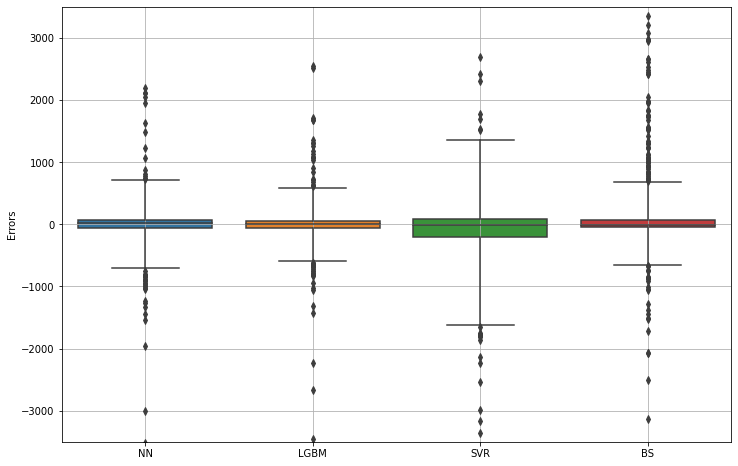

In [51]:
import seaborn as sns
errors = pd.DataFrame()

errors ['NN'] = nn_pred.reshape(-1) - test_labels.reshape(-1) 
errors ['LGBM'] = lgbm_pred.reshape(-1) - test_labels.reshape(-1)
errors ['SVR'] = svr_pred.reshape(-1)  - test_labels.reshape(-1)
errors ['BS'] = test_df ["BS"].values.reshape(-1) - test_labels.reshape(-1)

plt.figure(figsize=(12,8))
sns.boxplot(data=errors, whis=5)
plt.grid()
plt.ylim((-3500,3500))
plt.ylabel('Errors')
plt.savefig("errors_boxplot.png")
;

In [100]:
import seaborn as sns

''

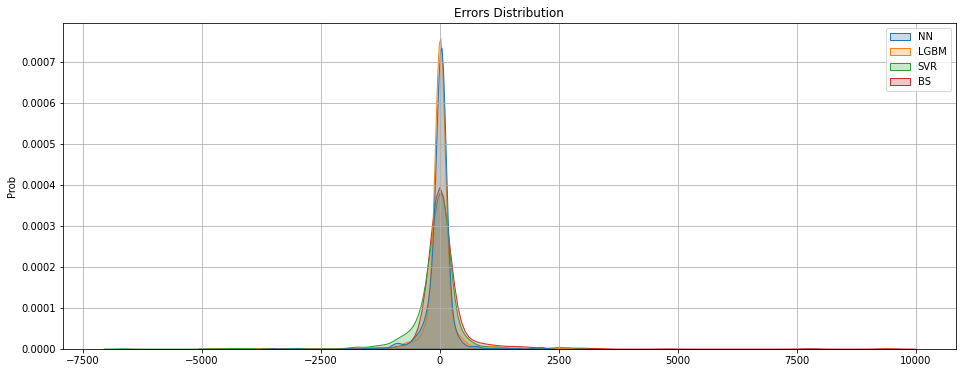

In [52]:
plt.figure(figsize=(16,6))
sns.kdeplot(data=errors,fill=0.3)
plt.grid()
# plt.ylim((-3500,3500))
plt.title("Errors Distribution")
plt.ylabel('Prob')
plt.savefig("errors_dist.png")
;

In [53]:
err_desc = errors.describe()
err_desc.columns = [col + ' errors' for col in err_desc.columns]
err_desc.T.to_csv("errors_tosifi.csv")

In [54]:
err_desc

,NN errors,LGBM errors,SVR errors,BS errors
count,1014.000000,1014.000000,1014.000000,1014.000000
mean,-14.412748,-2.561110,-109.271517,111.210398
std,324.884388,332.547545,590.792210,764.303120
min,-3512.150391,-3627.553093,-6617.949359,-4499.080793
25%,-61.790066,-53.387706,-197.123307,-49.185938
50%,17.955208,2.932040,-4.642849,-2.457327
75%,70.064152,54.802499,88.874895,74.195112
max,2190.068115,2548.762534,2685.905120,9406.878405
